In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import CrossEntropyLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from os.path import exists

from util import test_loss, train_NN

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

input_shape = (batch_size, 3, 32, 32)
num_labels = 10

Files already downloaded and verified
Files already downloaded and verified


In [14]:
from Models import LeNet

LeNN = LeNet(input_shape, num_labels, initial_lr=0.01, momentum=0.99, weight_decay=0)

summary(LeNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 32, 32]          456
│    └─BatchNorm2d: 2-2                  [100, 6, 32, 32]          12
│    └─Tanh: 2-3                         [100, 6, 32, 32]          --
│    └─AvgPool2d: 2-4                    [100, 6, 16, 16]          --
│    └─Conv2d: 2-5                       [100, 16, 16, 16]         2,416
│    └─BatchNorm2d: 2-6                  [100, 16, 16, 16]         32
│    └─Tanh: 2-7                         [100, 16, 16, 16]         --
│    └─AvgPool2d: 2-8                    [100, 16, 8, 8]           --
│    └─Flatten: 2-9                      [100, 1024]               --
│    └─Linear: 2-10                      [100, 120]                123,000
│    └─Tanh: 2-11                        [100, 120]                --
│    └

In [10]:
PATH = "models/LeNet_Cifar/LeNet.pth"

if exists(PATH):
    LeNN = torch.load(PATH)
    LeNN.eval()

In [15]:
criterion = CrossEntropyLoss()

train_NN(LeNN, criterion, train_dataloader,
        test_dataloader, epochs=20, batches_to_test=100,patience=2,device=device, print_test=True, verbose=True, p_randomTransform=0.5)

[1,   100] train_loss: 1.997
test_loss: 1.857, test_accuracy: 35.82
[1,   200] train_loss: 1.837
test_loss: 1.775, test_accuracy: 36.24
[1,   300] train_loss: 1.755
test_loss: 1.671, test_accuracy: 40.47
[1,   400] train_loss: 1.669
test_loss: 1.584, test_accuracy: 42.92
[1,   500] train_loss: 1.644
test_loss: 1.587, test_accuracy: 43.38
[2,   100] train_loss: 1.592
test_loss: 1.568, test_accuracy: 43.62
[2,   200] train_loss: 1.568
test_loss: 1.497, test_accuracy: 46.07
[2,   300] train_loss: 1.535
test_loss: 1.585, test_accuracy: 44.73
[2,   400] train_loss: 1.582
test_loss: 1.502, test_accuracy: 46.25
[2,   500] train_loss: 1.585
test_loss: 1.505, test_accuracy: 46.53
[3,   100] train_loss: 1.534
test_loss: 1.503, test_accuracy: 45.58
[3,   200] train_loss: 1.508
test_loss: 1.465, test_accuracy: 49.41
[3,   300] train_loss: 1.481
test_loss: 1.457, test_accuracy: 47.77
[3,   400] train_loss: 1.478
test_loss: 1.532, test_accuracy: 47.48
[3,   500] train_loss: 1.511
test_loss: 1.475, t

In [12]:
torch.save(LeNN, "./models/LeNet_Cifar/LeNet.pth")

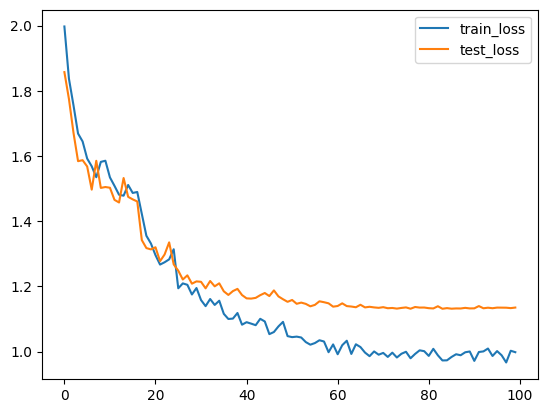

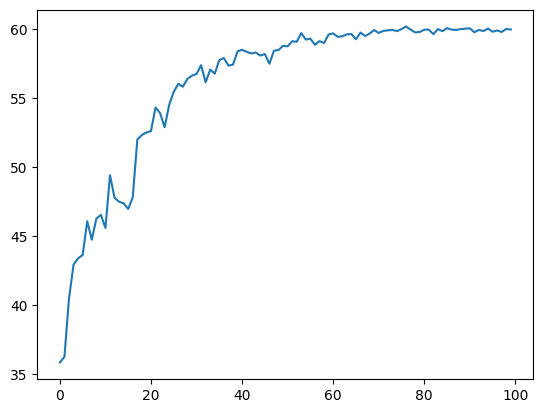

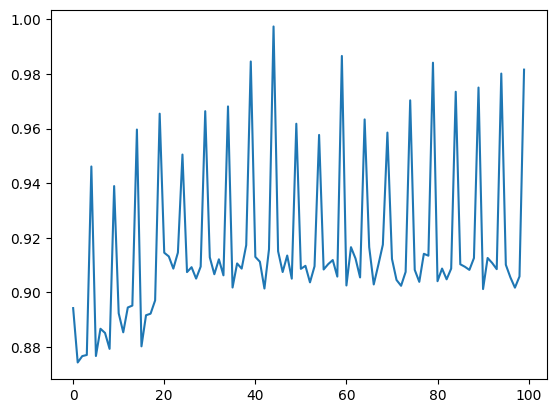

In [16]:
plt.plot(LeNN.train_loss, label="train_loss")
plt.plot(LeNN.test_loss, label = "test_loss")
plt.legend()
plt.show()
plt.plot(LeNN.test_accuracy)
plt.show()
plt.plot(LeNN.train_time)
plt.show()

In [18]:
from Models import LeASLNet

LeASLNN = LeASLNet(input_shape, num_labels, initial_lr=0.1, momentum=0.9, weight_decay=0, device=device, expansion_rate=1)

summary(LeASLNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeASLNet                                 [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 32, 32]          456
│    └─BatchNorm2d: 2-2                  [100, 6, 32, 32]          12
│    └─Tanh: 2-3                         [100, 6, 32, 32]          --
│    └─AvgPool2d: 2-4                    [100, 6, 16, 16]          --
│    └─CSC_block: 2-5                    [100, 16, 16, 16]         --
│    │    └─Sequential: 3-1              --                        108
│    │    └─Conv2d: 3-2                  [100, 16, 16, 16]         112
│    └─Tanh: 2-6                         [100, 16, 16, 16]         --
│    └─AvgPool2d: 2-7                    [100, 16, 8, 8]           --
│    └─Flatten: 2-8                      [100, 1024]               --
│    └─Linear: 2-9                       [100, 120]                123,000
│    └─

In [19]:
PATH = "models/LeNet_Cifar/LeASLNet.pth"

if exists(PATH):
    LeASLNN = torch.load(PATH)
    LeASLNN.eval()

In [20]:
criterion = CrossEntropyLoss()

train_NN(LeASLNN, criterion, train_dataloader,
        test_dataloader, epochs=4, batches_to_test=100,patience=2,device=device, print_test=True, verbose=True, p_randomTransform=0)

[1,   100] train_loss: 1.884
test_loss: 1.637, test_accuracy: 40.52
[1,   200] train_loss: 1.615
test_loss: 1.507, test_accuracy: 44.74
[1,   300] train_loss: 1.555
test_loss: 1.486, test_accuracy: 46.39
[1,   400] train_loss: 1.473
test_loss: 1.443, test_accuracy: 48.12
[1,   500] train_loss: 1.446
test_loss: 1.388, test_accuracy: 50.24
[2,   100] train_loss: 1.406
test_loss: 1.431, test_accuracy: 49.3
[2,   200] train_loss: 1.418
test_loss: 1.398, test_accuracy: 50.04
[2,   300] train_loss: 1.379
test_loss: 1.416, test_accuracy: 49.3
[2,   400] train_loss: 1.395
test_loss: 1.401, test_accuracy: 49.83
[2,   500] train_loss: 1.413
test_loss: 1.381, test_accuracy: 50.99
[3,   100] train_loss: 1.325
test_loss: 1.374, test_accuracy: 51.87
[3,   200] train_loss: 1.332
test_loss: 1.411, test_accuracy: 50.56
[3,   300] train_loss: 1.360
test_loss: 1.336, test_accuracy: 52.42
[3,   400] train_loss: 1.346
test_loss: 1.362, test_accuracy: 51.79
Epoch 00014: reducing learning rate of group 0 to 

In [25]:
torch.save(LeASLNN, "./models/LeNet_Cifar/LeASLNet.pth")

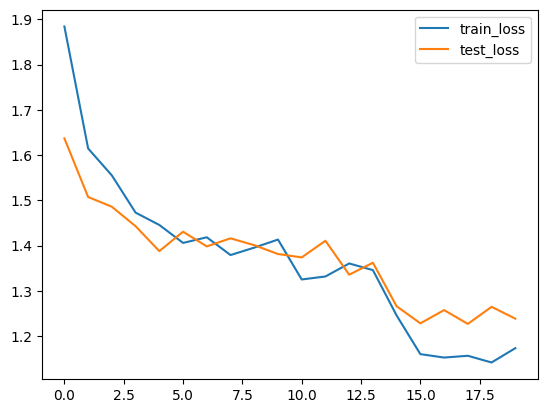

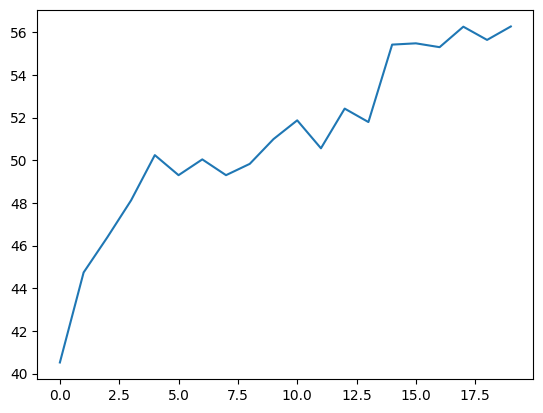

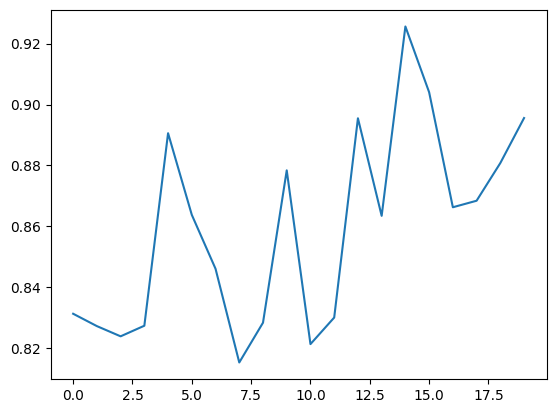

In [22]:
plt.plot(LeASLNN.train_loss, label="train_loss")
plt.plot(LeASLNN.test_loss, label="test_loss")
plt.legend()
plt.show()
plt.plot(LeASLNN.test_accuracy)
plt.show()
plt.plot(LeASLNN.train_time)
plt.show()

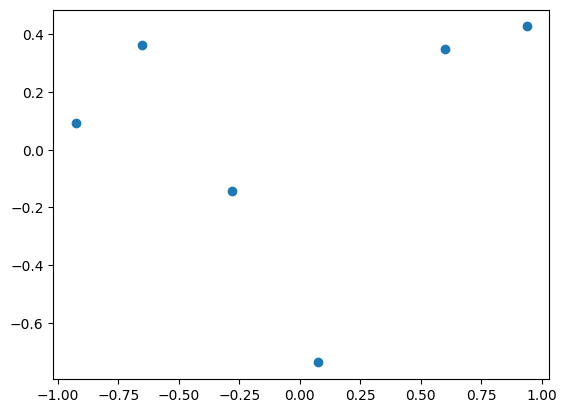

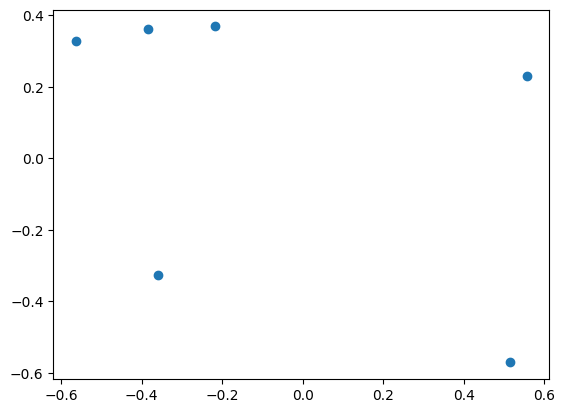

In [23]:
points = LeASLNN.NN[4].NN[3].shifts.detach().to("cpu").numpy()
initial_points = LeASLNN.NN[4].NN[3].initial.detach().to("cpu").numpy()
plt.scatter(initial_points[:, 0], initial_points[:,1])
plt.show()
plt.scatter(points[:, 0], points[:,1])
plt.show()

In [26]:
from Models import LeDepthNet

LeDepthNN = LeDepthNet(input_shape, num_labels, initial_lr=0.01, momentum=0.99, weight_decay=0, device=device)

summary(LeDepthNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeDepthNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 32, 32]          456
│    └─BatchNorm2d: 2-2                  [100, 6, 32, 32]          12
│    └─Tanh: 2-3                         [100, 6, 32, 32]          --
│    └─AvgPool2d: 2-4                    [100, 6, 16, 16]          --
│    └─Depth_wise_block: 2-5             [100, 16, 16, 16]         --
│    │    └─Sequential: 3-1              --                        226
│    └─Tanh: 2-6                         [100, 16, 16, 16]         --
│    └─AvgPool2d: 2-7                    [100, 16, 8, 8]           --
│    └─Flatten: 2-8                      [100, 1024]               --
│    └─Linear: 2-9                       [100, 120]                123,000
│    └─Tanh: 2-10                        [100, 120]                --
│    └─L

In [27]:
PATH = "models/LeNet_Cifar/LeDepthNet.pth"

if exists(PATH):
    LeDepthNN = torch.load(PATH)
    LeDepthNN.eval()

In [28]:
criterion = CrossEntropyLoss()

train_NN(LeDepthNN, criterion, train_dataloader,
        test_dataloader, epochs=4, batches_to_test=100,patience=2,device=device, print_test=True, verbose=True, p_randomTransform=0)

[1,   100] train_loss: 2.131
test_loss: 1.940, test_accuracy: 28.58
[1,   200] train_loss: 1.829
test_loss: 1.731, test_accuracy: 36.22
[1,   300] train_loss: 1.675
test_loss: 1.605, test_accuracy: 41.9
[1,   400] train_loss: 1.638
test_loss: 1.639, test_accuracy: 41.09
[1,   500] train_loss: 1.590
test_loss: 1.567, test_accuracy: 43.74
[2,   100] train_loss: 1.524
test_loss: 1.539, test_accuracy: 43.75
[2,   200] train_loss: 1.538
test_loss: 1.497, test_accuracy: 46.26
[2,   300] train_loss: 1.519
test_loss: 1.483, test_accuracy: 46.1
[2,   400] train_loss: 1.495
test_loss: 1.442, test_accuracy: 47.92
[2,   500] train_loss: 1.463
test_loss: 1.479, test_accuracy: 46.49
[3,   100] train_loss: 1.455
test_loss: 1.505, test_accuracy: 46.94
[3,   200] train_loss: 1.462
test_loss: 1.472, test_accuracy: 48.47
[3,   300] train_loss: 1.444
test_loss: 1.457, test_accuracy: 48.0
[3,   400] train_loss: 1.417
test_loss: 1.424, test_accuracy: 49.04
[3,   500] train_loss: 1.410
test_loss: 1.415, test

In [29]:
torch.save(LeDepthNN, "./models/LeNet_Cifar/LeDepthNet.pth")

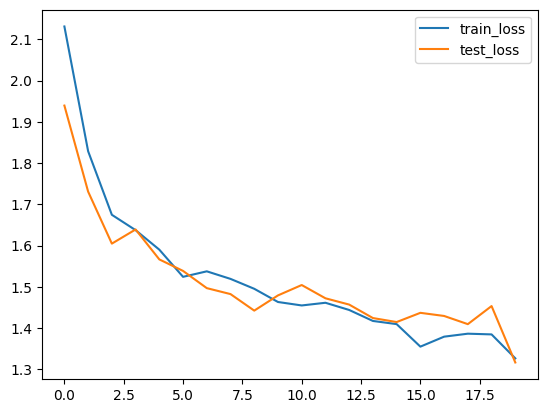

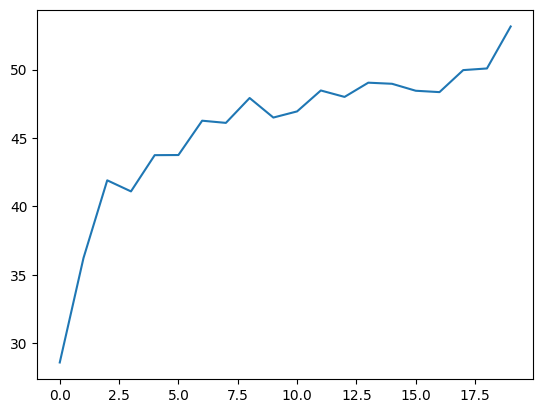

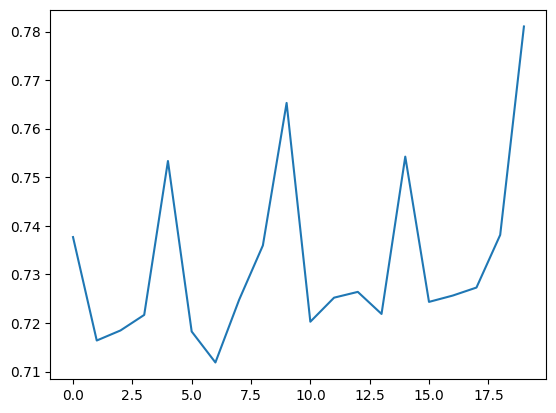

In [30]:
plt.plot(LeDepthNN.train_loss, label="train_loss")
plt.plot(LeDepthNN.test_loss, label="test_loss")
plt.legend()
plt.show()
plt.plot(LeDepthNN.test_accuracy)
plt.show()
plt.plot(LeDepthNN.train_time)
plt.show()

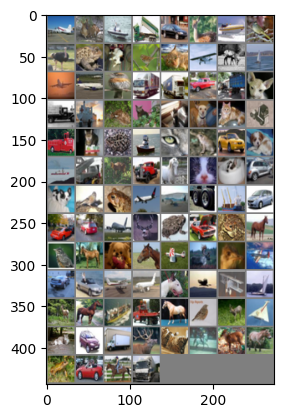

plane deer  ship  truck car   deer  ship  bird  bird  frog  cat   bird  cat   plane deer  ship  plane plane bird  truck truck car   truck cat   truck ship  deer  cat   cat   dog   cat   truck truck cat   frog  ship  cat   frog  car   dog   ship  truck deer  truck horse cat   dog   car   dog   bird  frog  plane plane truck ship  car   car   car   plane deer  frog  car   frog  horse bird  horse dog   horse plane deer  bird  plane car   car   plane plane dog   bird  plane ship  deer  horse ship  truck horse bird  deer  plane cat   car   truck deer  cat   horse deer  horse frog  car   horse truck


In [31]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))